# __D213 PA Task 1:__ *ARIMA Time-series analysis*
>### Aaminah Halipoto
>### Western Governor's University
>### D213: Advanced data analytics
>### Prof. William Sewell
>### Nov 13. 2024


### Table of Contents
>A1. [Research Question](#question) </br>
A2. [Objectives or Goals](#goal)</br>
B1. [Summary of Assumptions](#summary)</br>
C1. [Line graph visualization](#linegraph)</br>
C2. [Time step formatting](#timestep)</br>
C3. [Stationarity](#stationarity)</br>
C4. [Steps to prepare the data](#steps)</br>
C5. [Prepared dataset](#dataset)</br>
D1. [Report findings and visualizations](#findings)</br>
D2. [ARIMA model](#arima)</br>
D3. [Forecasting using ARIMA model](#forecasting)</br>
D4. [Output and calculations](#output)</br> 
D5. [Code](#code)</br>
E1. [Results](#results)</br>
E2. [Annotated visualization](#annotated)</br>
E3. [Recommendation](#rec)</br>
F. [Reporting](#report)</br>
G. [Sources for third-party code](#sourcescode)</br>
H. [Sources](#sources)</br>


#### __A1. Research Question__ <a name="question"></a>
Using ARIMA modelling and the past two years of data, can we accurately forecast future daily revenue for the next three months?

#### __A2. Objectives or Goals__ <a name="goal"></a>
I intend to use ARIMA analysis models to support the finding of time-based trends within the pasty two years of revenue data, in order to predict revenue for the next three months.

#### __B1. Summary of Assumptions__ <a name="summary"></a>
According to Joseph Noble of IBM, ARIMA is a time-series analysis method which merges two pre-existing models to predict future values: autoregressive modeling and moving average modeling. Autoregressive modeling (AR) is when a variable is regressed on its own previous or lagged values. Moving average modeling (MA) is explained by J Hyndman and Athanasopoulos as linear regression modeling of a forecast's errors, rather than the values outright. ARIMA is then, as an integration of these two models, a more general and widely-applicable process that can forecast future trends from time-series data. Three values are arguments of the ARIMA model alongside the data -- they refer to: 
>p, the number of lag observations, </br>
>d, the number of differencing operations performed to make the data stationary, and</br>
>q, the number of errors in the lagged forecast (Sewell, 2024).</br>

ARIMA is performed based on the assumption that the time-data involved can be transformed to become stationary -- meaning that time is no longer a function of the data, and the mean and variance remain constant throughout the dataset (IBM). The number of times necessary to difference the data and transform it to become stationary determines the (d) value for the ARIMA model. We also assume that the data is correlated to itself, which we find by lagging the dataset against its own values. Autocorrelated values are important to modeling as significant points of correlation between adjacent lags indicates the (q) value found by graphing the autocorrelation function, as well as the correlation between varying amounts of lag indicating the (p) value found by graphing the partial autocorrelation function (Sewell, 2024).

In [11]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sb
import tensorflow
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (10, 6)

#Importing the transaction data, dropping possible NA
df = pd.read_csv('C://Users/Aaminah/Desktop/masters/d213/teleco_time_series.csv')
df.dropna()
print('Shape of data:', df.shape)
df.head()

Shape of data: (731, 2)


,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [12]:
#simple data cleaning steps to ensure no duplicates
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
726    False
727    False
728    False
729    False
730    False
Length: 731, dtype: bool

In [13]:
#ensuring no nulls
df.isnull().any()

Day        False
Revenue    False
dtype: bool

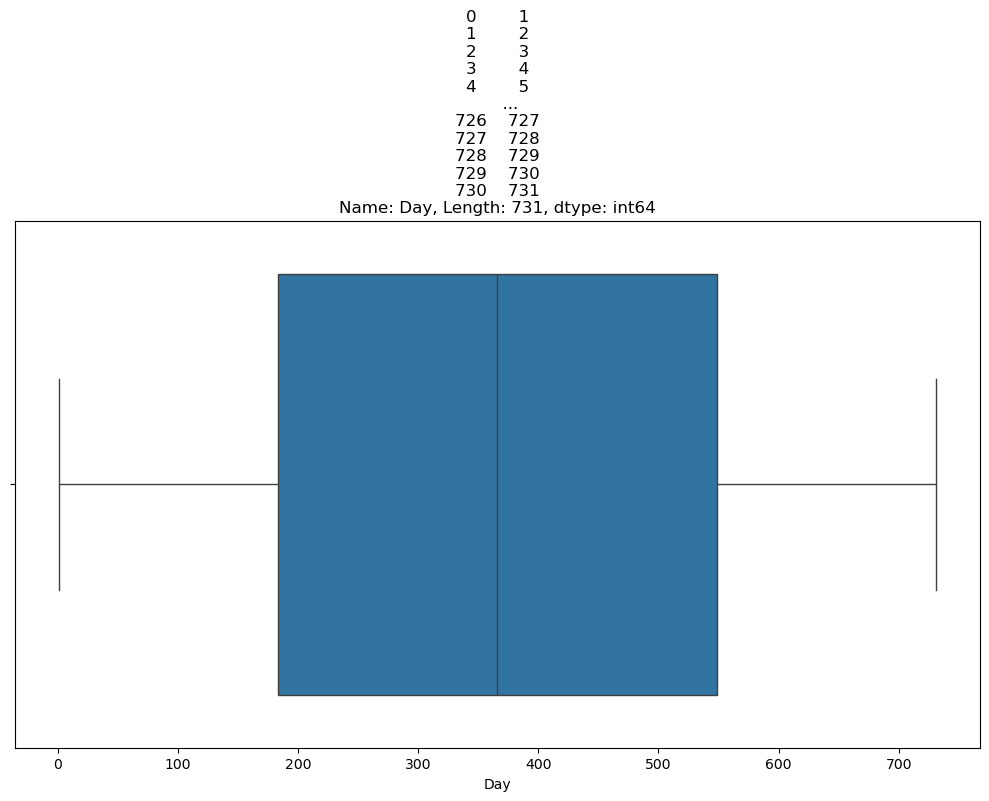

In [14]:
#ensuring no outliers
boxplot = sb.boxplot(x=df['Day'], data=df)
plt.tight_layout()
plt.title(df['Day'])
plt.show()

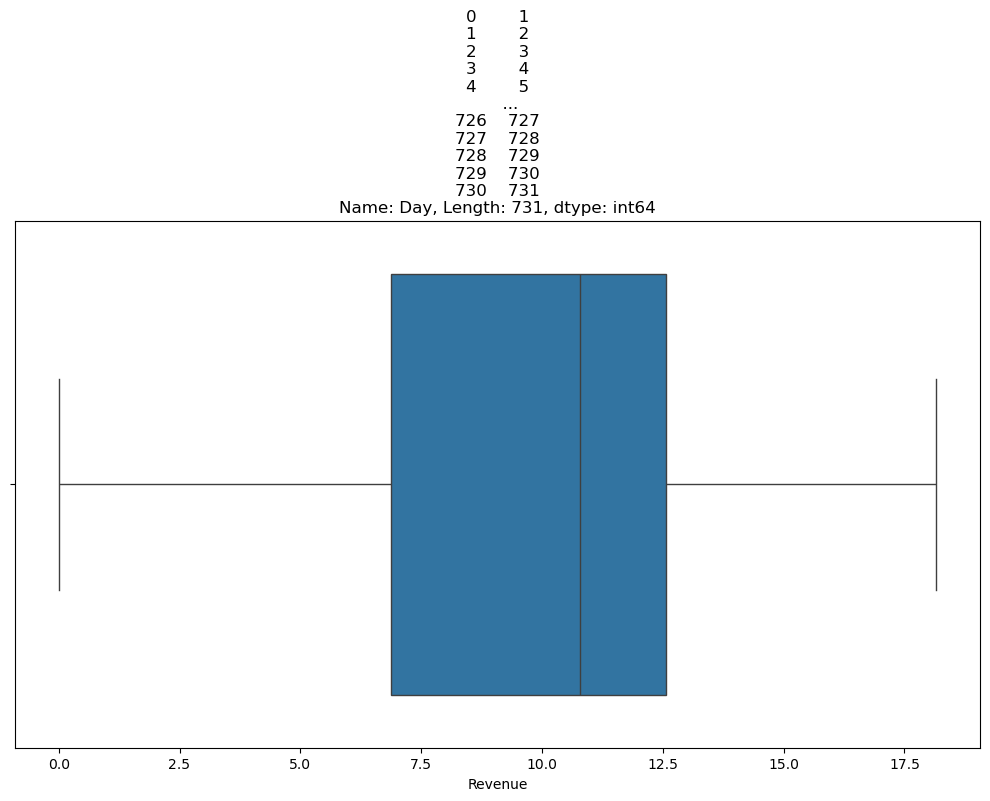

In [15]:
boxplot = sb.boxplot(x=df['Revenue'], data=df)
plt.tight_layout()
plt.title(df['Day'])
plt.show()

#### __C1. Line graph visualization__ <a name="linegra"></a>
Below is the initial scatterplot of the revenue data over the period of 2 years. 

Text(0, 0.5, 'Revenue (millions USD)')

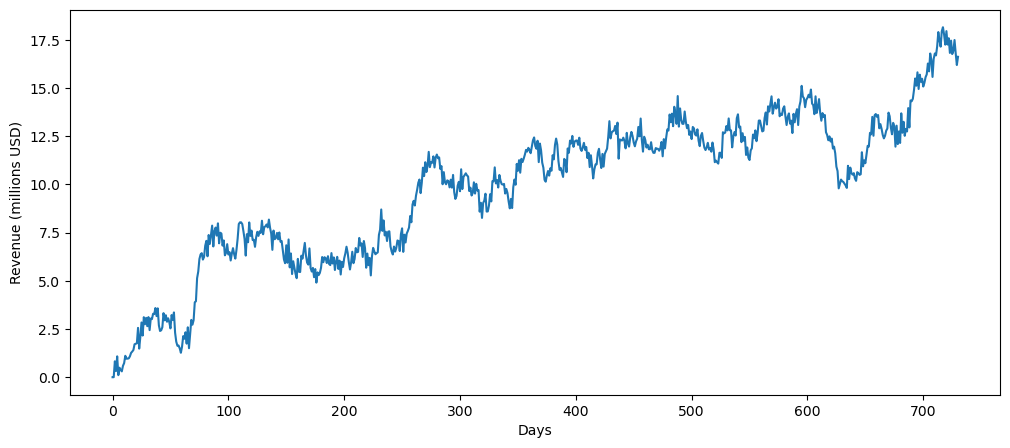

In [17]:
df['Revenue'].plot(figsize=(12,5))
plt.xlabel('Days')
plt.ylabel('Revenue (millions USD)')

#### __C2. Time step formatting__ <a name="timestepAc"></a>
The time step format of the above data is measured in days. There appear to be no gaps in measurement nor length of the sequence -- I account 731 days of revenue recorded, which amounts to 2 full years. Below, I illustrate the process of converting the days (count) to datetime format, starting at January 1, 2021. This ensures that all datetime values are present and in order within the time-series data.

In [19]:
#(Geeksforgeeks)
#generating usable dates to convert 'Day' column to datetime
Date_range = pd.date_range(start='1/1/2021', end='01/01/2023', freq='D') 
print(Date_range) 
  
print(type(Date_range)) 
print(type(Date_range[0])) 

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01'],
              dtype='datetime64[ns]', length=731, freq='D')
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [20]:
#assigning new datetime values to 'Day' column and setting the index
df['Day'] = Date_range
df = df.set_index('Day') 
print(df.head()) 

             Revenue
Day                 
2021-01-01  0.000000
2021-01-02  0.000793
2021-01-03  0.825542
2021-01-04  0.320332
2021-01-05  1.082554


#### __C3. Stationarity__ <a name="stationarity"></a>
Now that the dataset is in time-series format, we can start evaluating its stationarity, found by performing the augmented Dickey-Fuller test.

The augmented Dickey-Fuller test below has an insignificant p-value greater than the alpha, 0.05. Additionally, the absolute value of the critical values are all greater than the absolute value of the ADF test-statistic (1.924612157310183), all of which means that the data is not stationary (Sewell, 2024). 

In [22]:
#p value is not significant, so the data is not stationary
#absvalue of critical values are greater than the adf statistic, which is bad
print ('Results of Dickey-Fuller test: ')

dftest = adfuller(df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','No. of Observations'])

for key,value in dftest[4].items():
	dfoutput['Critical Value (%s) '%key] = value # Critical Values should always be more than the test statistic

print(dfoutput)

Results of Dickey-Fuller test: 
Test Statistic            -1.924612
p-value                    0.320573
#Lags Used                 1.000000
No. of Observations      729.000000
Critical Value (1%)       -3.439352
Critical Value (5%)       -2.865513
Critical Value (10%)      -2.568886
dtype: float64


Using pandas <diff()> function, I address the non-stationarity within the time-series data by differencing each record by a lag of 1. This transforms the dataset to revolve around a constant, where the mean and variance is expected to be 0. This is illustrated in the graph below, where the differenced time-series data now clearly revolves around a mean of 0.

In [24]:
#original dataset values, for comparison
df.head()

,Revenue
Day,
2021-01-01,0.000000
2021-01-02,0.000793
2021-01-03,0.825542
2021-01-04,0.320332
2021-01-05,1.082554


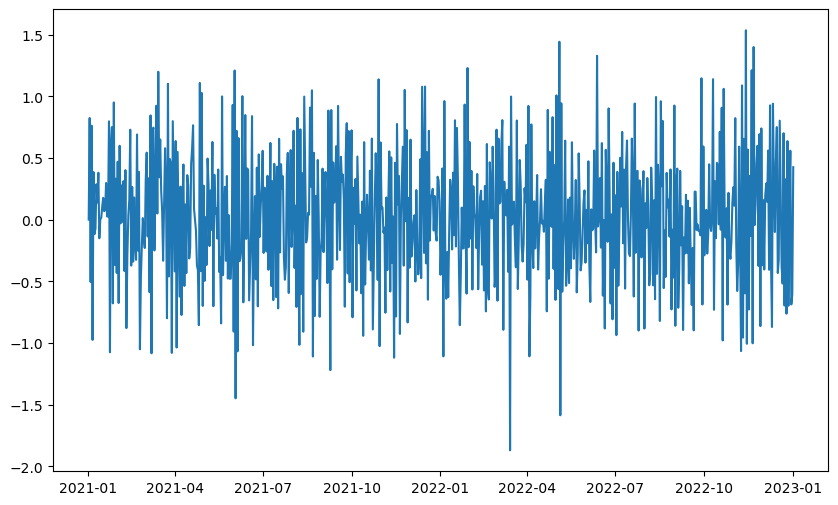

In [25]:
#differencing the revenue data
diffed = df.diff()
plt.plot(diffed)
plt.show()

In [26]:
#differenced values - note the NaN in record 1
diffed.head()

,Revenue
Day,
2021-01-01,NaN
2021-01-02,0.000793
2021-01-03,0.824749
2021-01-04,-0.505210
2021-01-05,0.762222


With the differenced data, I re-run ADF in hopes that with the stabilized mean, we have a significant p-value and small critical values compared to the test statistic. I illustrate this process below. With a p-value of 0.000 along with the comparatively small critical values, we can reject the null hypothesis that the data is non-stationary. The mean and standard deviation have leveled out, and we can move on to identifying aspects of seasonality and significant lag values in the data.

In [28]:
#dropping the initial value in diffed, which is NaN after differencing
diffed.dropna(inplace=True)
#performing ADF on differenced data
print ('Results of Dickey-Fuller test: ')

dftest = adfuller(diffed, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','No. of Observations'])

for key,value in dftest[4].items():
	dfoutput['Critical Value (%s) '%key] = value # Critical Values should always be more than the test statistic

print(dfoutput)

Results of Dickey-Fuller test: 
Test Statistic           -44.874527
p-value                    0.000000
#Lags Used                 0.000000
No. of Observations      729.000000
Critical Value (1%)       -3.439352
Critical Value (5%)       -2.865513
Critical Value (10%)      -2.568886
dtype: float64


#### __C4. Steps to prepare the data__ <a name="steps"></a>
The entire script is located in the document 'ahalipoto_pa3.ipynb'.

#### __C5. Prepared dataset__ <a name="dataset"></a>
I perform an 80/20 training/test split by assigning 585 days to training, 146 days to testing. This process is illustrated in the cells below, and the .csv files containing each training set included in submission.

In [31]:
X_train = df.loc[: '2022-08-08']
X_test = df.loc['2022-08-09' :]

print('X_train shape ', X_train.shape)
print('X_test shape ', X_test.shape)

X_train shape  (585, 1)
X_test shape  (146, 1)


In [32]:
X_train.to_csv('C://Users/Aaminah/Desktop/masters/d213/pa1_xtrain.csv', index=False)
X_test.to_csv('C://Users/Aaminah/Desktop/masters/d213/pa1_xtest.csv', index=False)

#### __D1. Report findings and visualizations__ <a name="findings"></a>
Because I have a properly-differenced dataset, it's now possible to extract findings for the ARIMA formula as well as evaluate seasonality and trends. Below is a the decomposition of the differenced dataset, showing the observed data, its trends, the measure of seasonality, as well as the "residuals of the time serious after the trend and seasonal components are removed" (Brownlee, 2020). 

There is a distinct trend in the data remaining after seasonality is removed, and there is very little seasonality indicated by the presence of a peak near the end of the data. The residuals also offer little in terms of a pattern, displaying lots of noise present in the differenced dataset. 

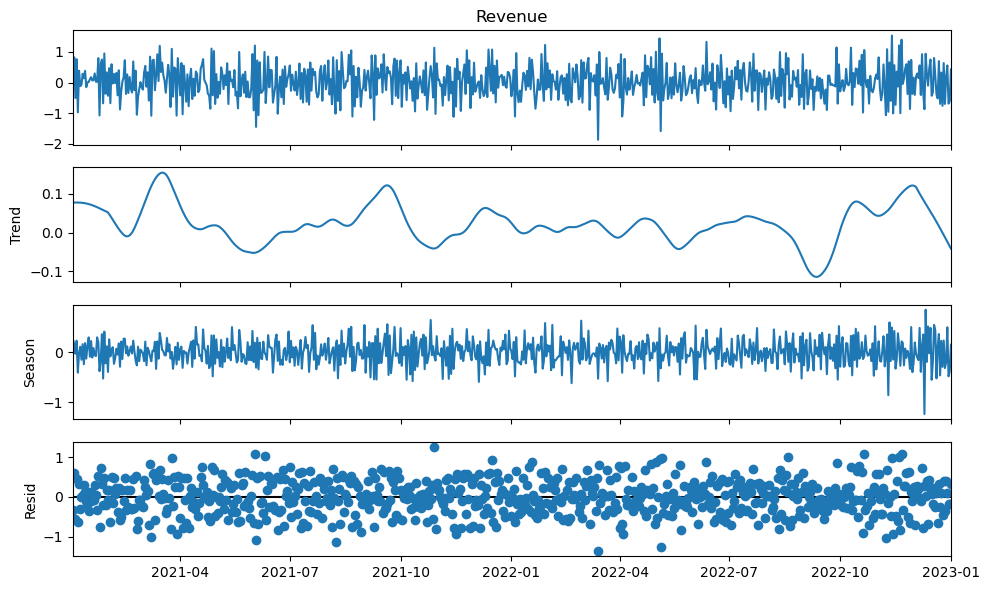

In [34]:
stl = STL(diffed['Revenue'], period = 30)
res = stl.fit()
fig = res.plot()
fig.figsize=16,6

Spectral density graphs give an indication of observable patterns present in the data, and whether seasonality is affecting revenue. The repeated low peaks are clear indications of some type of seasonality within the revenue data.

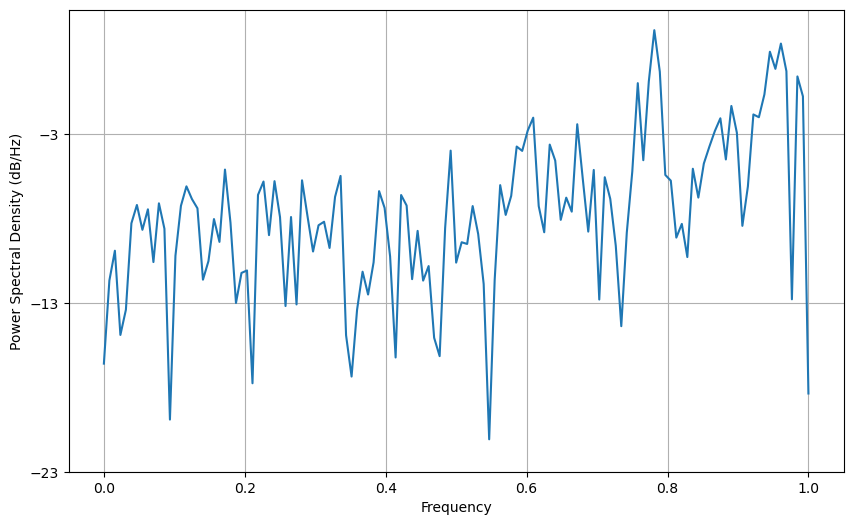

In [36]:
#power spectral density graph
plt.psd(diffed['Revenue'])
plt.show()

Autocorrelation functions (ACF) and the partial autocorrelation functions (PACF) are graphs representing the relationship between differences in adjacent lags. ACF measures the correlation between points amongst different lag lengths, where PACF measures controlled correlations "between observations of a shorter lag length" (Predictive Analytical Resources Limited, 2021).

After charting the functions, I can differentiate the most significant lags at lag=2 for ACF, and lag=1 for PACF. The ACF informs a good fit for the (q) value, and PACF informs for the (p) value (Sewell, n.d. -a)

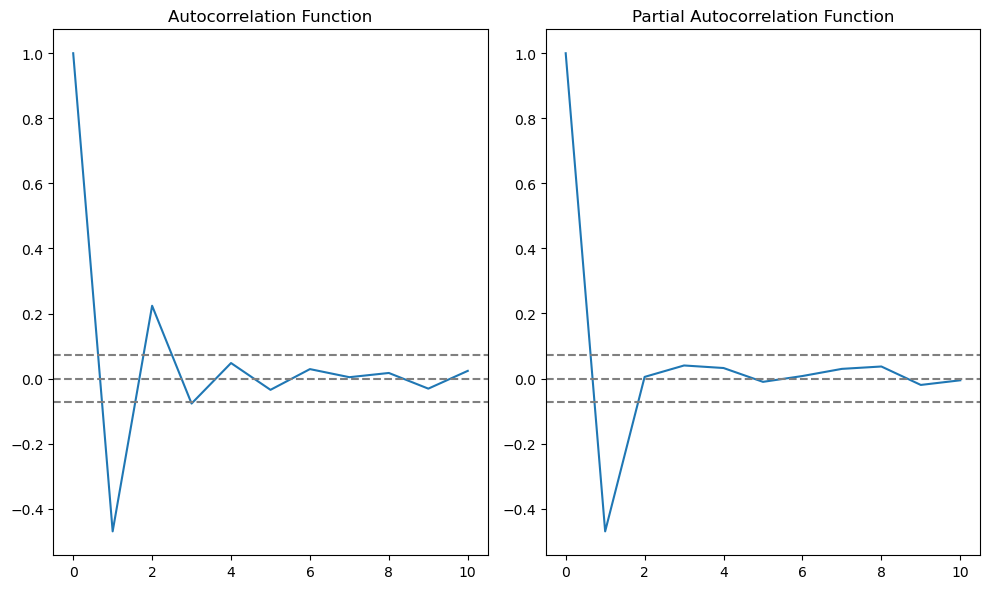

In [38]:
#Performing acf and pacf on differenced data to find p and q values. 
lag_acf = acf(diffed, nlags=10)
lag_pacf = pacf(diffed, nlags=10, method='ols')

# plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diffed)), linestyle='--', color='gray')
plt.axhline(y= 1.96/np.sqrt(len(diffed)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diffed)), linestyle='--', color='gray')
plt.axhline(y= 1.96/np.sqrt(len(diffed)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Additionally, I can run an auto-ARIMA test to get a sense of what values are most appropriate for the ARIMA model. The values (1, 1, 0) seem to give the model with the lowest AIC, which indicates the superiority of this model over others. This is also corroborated in part by our findings above, where the most optimal (p) value is 1, and the data having been differenced once to achieve stationarity suggests an optimal (d) value of 1. 

It is interesting that the value for (q) is suggested by auto-ARIMA to be 0, rather than 2 as seen in the autocorrelation function. Only by comparing models will I be able to tell which value of (q) is best.

In [40]:
stepwise_fit = auto_arima(df['Revenue'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.393 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Mon, 18 Nov 2024   AIC                            983.122
Time:                        12:27:01   BIC                            996.901
Sample:                    01-01-2021   HQIC                           988.438
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### __D2. ARIMA model__ <a name="arima"></a>
Using the (p, d, q) values generated in analyses from SARIMAX, ACF and PACF, as well as findings from spectral density analysis and decomposition, it's possible to begin generating ARIMA models on the Churn revenue training dataset. 

Below illustrates the best model, noted by the lowest possible AIC (774.990) and significant p-values. Consequent models are demonstrated as well, to show their deficiencies compared to ARIMA with the order of (1, 1, 0).

In [42]:
#Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
model = ARIMA(X_train['Revenue'], order = (1, 1, 0))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  585
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -385.495
Date:                Mon, 18 Nov 2024   AIC                            774.990
Time:                        12:27:01   BIC                            783.730
Sample:                    01-01-2021   HQIC                           778.397
                         - 08-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.036    -12.605      0.000      -0.528      -0.386
sigma2         0.2191      0.014     15.965      0.000       0.192       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.90   Prob(JB):                         0.40
Heteroskedasticity (H):               0.96   Skew:                            -0.08
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
#poorer model using autocorrelation value of (q) = 2, note the AIC compared to the best: 777.060 > 774.990
dummy_model = ARIMA(X_train['Revenue'], order = (1, 1, 2))
dummy_model = dummy_model.fit()
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  585
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -384.530
Date:                Mon, 18 Nov 2024   AIC                            777.060
Time:                        12:27:02   BIC                            794.540
Sample:                    01-01-2021   HQIC                           783.873
                         - 08-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2722      0.174     -1.565      0.118      -0.613       0.069
ma.L1         -0.1829      0.175     -1.045      0.296      -0.526       0.160
ma.L2          0.1146      0.083      1.389      0.165      -0.047       0.276
sigma2         0.2184      0.014     15.705      0.000       0.191       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               0.97   Skew:                            -0.10
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
#random walk -- very high AIC of 909.948 >> 774.990
dummy_model = ARIMA(X_train['Revenue'], order = (0, 1, 0))
dummy_model = dummy_model.fit()
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  585
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -453.974
Date:                Mon, 18 Nov 2024   AIC                            909.948
Time:                        12:27:02   BIC                            914.318
Sample:                    01-01-2021   HQIC                           911.651
                         - 08-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2772      0.017     16.130      0.000       0.243       0.311
===================================================================================
Ljung-Box (L1) (Q):                 124.42   Jarque-Bera (JB):                 2.28
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               0.93   Skew:                            -0.12
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#seasonal model with high AIC of 941.499 >> 774.990
dummy_model = ARIMA(X_train['Revenue'], order=(0, 1, 0), seasonal_order=(1,1,1,12))
dummy_model = dummy_model.fit()
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                  585
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -467.750
Date:                            Mon, 18 Nov 2024   AIC                            941.499
Time:                                    12:27:03   BIC                            954.547
Sample:                                01-01-2021   HQIC                           946.589
                                     - 08-08-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0214      0.047     -0.455      0.649      -0.114       0.071
ma.S.L12      -0.9977      0.422     -2.366      0.018      -1.824      -0.171
sigma2         0.2774      0.114      2.433      0.015       0.054       0.501
===================================================================================
Ljung-Box (L1) (Q):                 126.78   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.90   Skew:                            -0.10
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Having produced the best model possible and fitting it to the training dataset, I test predictions in the interval of time that covers the testing dataset. In this case, because I performed an 80/20 split, I'm predicting for 146 days. 

In [47]:
#(Sewell, n.d.-a)
#making predictions
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model.predict(start=start, end=end, typ='levels')
print(pred)

pred.index= df.index[start:end+1]

2022-08-09    13.602625
2022-08-10    13.640176
2022-08-11    13.623022
2022-08-12    13.630859
2022-08-13    13.627279
                ...    
2022-12-28    13.628401
2022-12-29    13.628401
2022-12-30    13.628401
2022-12-31    13.628401
2023-01-01    13.628401
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


Below is the plot of the predicted values for the end of 2023, alongside the actual test data. Note that the predicted data is nearly constant, but still centers around the mean of the test data. 

<Axes: xlabel='Day'>

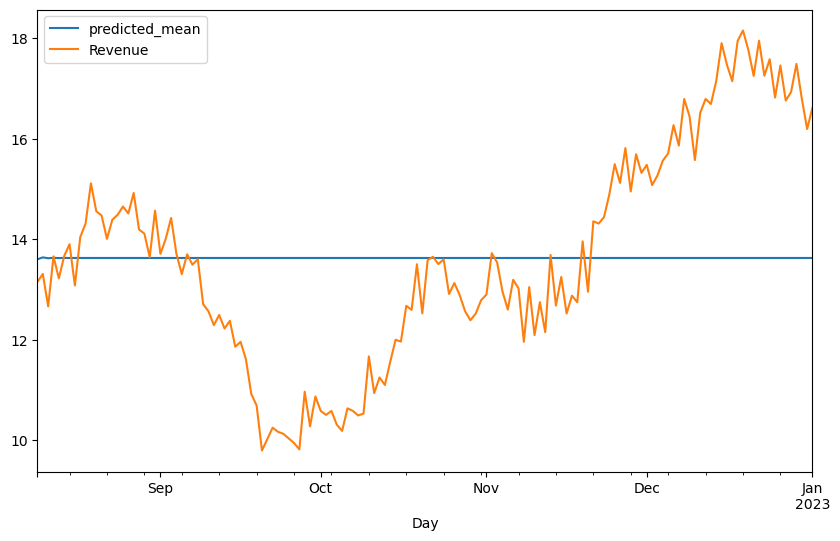

In [49]:
pred.plot(legend=True)
X_test['Revenue'].plot(legend=True)

In [50]:
#mean of test values is very similar to the predicted
print(f'Mean of the testing data is {X_test['Revenue'].mean()}')
print(f'Mean of the predicted data is {pred.mean()}')

Mean of the testing data is 13.644811365719177
Mean of the predicted data is 13.6282800226741


As the means of the predicted and test data are very similar, I can find the mean squared error to assess the fit of the model. A low root MSE is an indication of a good fit, corroborated by the value I find at 2.1667.

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, X_test['Revenue']))
print(rmse)

2.1666421288201754


Having assessed the model's fit, I can now run the model on the entirely of the original dataset. This will be used to give an accurate forecast for future dates.

In [54]:
model2 = ARIMA(df['Revenue'], order=(1,1,0))
model2 = model2.fit()
df.tail()

,Revenue
Day,
2022-12-28,16.931559
2022-12-29,17.490666
2022-12-30,16.803638
2022-12-31,16.194813
2023-01-01,16.620798


#### __D3. Forecasting using ARIMA model__ <a name="forecasting"></a>
Forecasting involves the <get_forecast> function from ARIMA, and I input 90 steps as the number of days that I want to predict. The mean of this prediction is then graphed alongside the confidence intervals for the forecast.

In [56]:
diff_forecast = model2.get_forecast(steps=90)
mean_forecast = diff_forecast.predicted_mean
confidence_intervals = diff_forecast.conf_int()
lower_limits = confidence_intervals.loc[:, 'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']
print(diff_forecast)

#### __D4. Output and calculations__ <a name="output"></a>
Below are outputs obtained from splitting the data, running an intermediate model with findings from my own autocorrelation functions, finding the final model's RMSE, and calculating the mean of the original data.

In [58]:
#split data 80/20
print('X_train shape ', X_train.shape)
print('X_test shape ', X_test.shape)

X_train shape  (585, 1)
X_test shape  (146, 1)


In [59]:
#poorer model using autocorrelation value of (q) = 2, note the AIC compared to the best: 777.060 > 774.990
dummy_model = ARIMA(X_train['Revenue'], order = (1, 1, 2))
dummy_model = dummy_model.fit()
dummy_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  585
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -384.530
Date:                Mon, 18 Nov 2024   AIC                            777.060
Time:                        12:27:04   BIC                            794.540
Sample:                    01-01-2021   HQIC                           783.873
                         - 08-08-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2722      0.174     -1.565      0.118      -0.613       0.069
ma.L1         -0.1829      0.175     -1.045      0.296      -0.526       0.160
ma.L2          0.1146      0.083      1.389      0.165      -0.047       0.276
sigma2         0.2184      0.014     15.705      0.000       0.191       0.246
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.88   Prob(JB):                         0.26
Heteroskedasticity (H):               0.97   Skew:                            -0.10
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
#assessing to find goodness of fit
print(rmse)

2.1666421288201754


In [61]:
#mean of test values is very similar to the predicted
print(f'Mean of the testing data is {X_test['Revenue'].mean()}')
print(f'Mean of the predicted data is {pred.mean()}')

Mean of the testing data is 13.644811365719177
Mean of the predicted data is 13.6282800226741


#### __D5. Code__ <a name="code"></a>
Code for the entirety of data processing and modeling is found within "ahalipoto_pa1.ipynb'.

#### __E1. Results__ <a name="results"></a>
__Selection of Arima__
ARIMA models can be evaluated by the Akaike information criterion or AIC for short. The smallest value of AIC amongst many models indicates the model's superiority in terms of accuracy and representation of the original data. After creating a model with the order gained from auto-ARIMA, I permutated the (p, d, q) values in subsequent models to compare their AIC values. The first model with the order (1, 1, 0) had the lowest AIC of 774.990. Adjusting ARIMA orders with seasonality also gave poor outcomes with high AIC, meaning the little amount of seasonality present in the data is insignificant and unaccounted for. 
__Prediction interval of the forecast and justification of forecast length____
The original data spans 2 years of records, so it is nonsensical to forecast longer lengths of time. The shorter the forecast period, the more accurate the results are. I chose 3 months or 90 days to forecast as its a comparative 12.5% of the original timespan, and I felt that this is a useful amount of time to forecast before diminishing returns on accuracy set in. 
__Model evaluation and error metric__
In addition to the low AIC, the model is evaluated on other measures. The p-values for each component were 0.000, indiciating significance of the model. Additionally, finding the root mean squared error is a good way to strike out models with poor performance. A large RMSE indicates there is a better model to generate, but I found a low RMSE of 2.1667 which is very close to 0. This is a good indication of my model representing the data.

#### __E2. Annotated visualization__ <a name="annotated"></a>
Below is the annotated visualization of the forecast vs the prediction vs the testing and training data. The confidence intervals are quite large and should account for any variance within the predictions. The predicted and forecasted mean is almost completely constant with little to no seasonality -- this is likely due to the best model not accounting for the scant seasonality present in the original data. However, this forecast is still legitimate and provides a baseline for further analysis. 

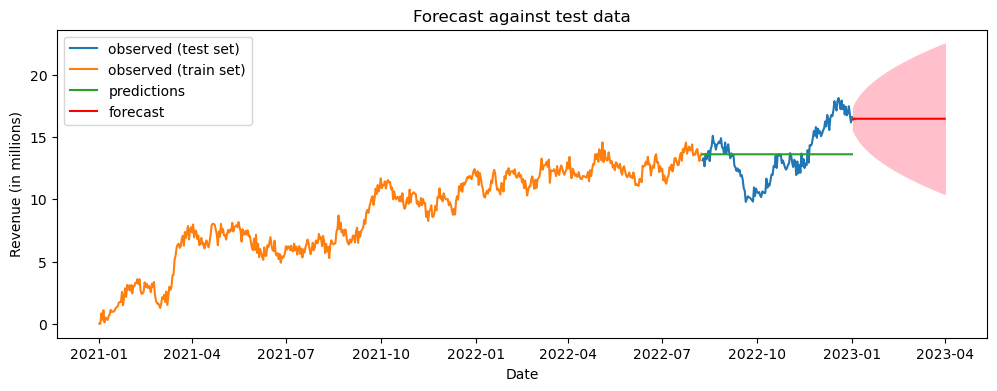

In [65]:
plt.figure(figsize=(12,4))
plt.plot(X_test.index, X_test, label='observed (test set)')
plt.plot(X_train.index, X_train, label = 'observed (train set)')
plt.plot(pred.index, pred, label = 'predictions')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

plt.title('Forecast against test data')
plt.xlabel('Date')
plt.ylabel('Revenue (in millions)')
plt.legend()
plt.show()

#### __E3. Recommendation__ <a name="rec"></a>
Time series analysis allows us to look at trends and reliably predict future values in order to make good decisions. From my analysis, I've been able to form a prediction of future values (even if slightly inaccurate) that may form the basis of informed practices and policies for months to come. The above visualization of my prediction contains a mean prediction as well as confidence interval for future revenue values: despite the trend being mostly constant, we can still reliably make plans within confidence for revenue to not fall below the threshold of ~$11 million USD in the months of 2023. We may experience revenue up to the early 20 millions, if we play our cards right. I did not find much basis for strong seasonality, so going forward we need not account for trends based on the time of year. We will experience oscillating revenue as per the general trend, and we can mitigate losses by maintaining our margins and ensuring our foundational  business strategies are strong. I would advise making safe decisions and watching the pattern of revenue growth/decay before proceeding. All in all, our trend nets positively. Using the forecast from ARIMA model can help us keep it that way.

#### __F. Reporting__ <a name="report"></a>
This presentation is included as an HTML document 'ahalipoto_pa1.html'.

#### __G. Sources for third-party code__ <a name="sourcescode"></a>
Brownlee, J. (2020, December 9). How to decompose time series data into trend and seasonality. MachineLearningMastery.com. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/ 

Brownlee, J. (2020a, August 14). How to difference a time series dataset with python. MachineLearningMastery.com. https://machinelearningmastery.com/difference-time-series-dataset-python/ 

GeeksforGeeks. (2022b, March 18). Manipulating time series data in Python. https://www.geeksforgeeks.org/manipulating-time-series-data-in-python/ 

Sewell, W. (n.d.-b). D213 ARIMA I. WGU. https://westerngovernorsuniversity-my.sharepoint.com/:p:/g/personal/william_sewell_wgu_edu/EftnPPOZu8RNvZIbxqAUX0UBasp-mA6k2OJXTM0Vd4bR7A?e=r1o26B 

Sewell, W. (n.d.-c). Time Series Analysis - D213 Advanced Data Analytics Arima Modeling 2. SRM. https://srm--c.vf.force.com/servlet/fileField?retURL=https%3A%2F%2Fsrm--c.vf.force.com%2Fapex%2FCourseArticle%3Fid%3DkA0S60000000nyPKAQ%26groupId%3D%26searchTerm%3D%26courseCode%3DD213%26rtn%3D%252Fapex%252FCommonsExpandedSearch&entityId=ka0S60000004X3pIAE&_CONFIRMATIONTOKEN=VmpFPSxNakF5TkMweE1TMHhObFF3TURvME5EbzFPUzR4T1RWYSxGdjgzSzZkSEZNV3FRVWs5c3VYUVN4Nko2OXdyR0JpbVlDd2FtZ210OGpNPSxaREZrWVdOaQ%3D%3D&common.udd.actions.ActionsUtilORIG_URI=%2Fservlet%2FfileField&field=FileUpload2__Body__s 

#### __H. Web Sources__ <a name="sources"></a>
J Hyndman, R., and Athanasopoulos, G. (n.d.). Forecasting: Principles and practice (2nd ed). 8.4 Moving average models. https://otexts.com/fpp2/MA.html 

Kamara, K. (n.d.). Data Mining II - D212 Theory. Panopto. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=9541a29b-2f14-4c5d-9d86-af030005bcf6

Noble, J. (2024, August 19). What are Arima Models?. IBM. https://www.ibm.com/topics/arima-model

Predictive Analytical Resources Limited. (2021, November 3). Time Series Analysis: A short introduction to ACF, PACF and differencing. LinkedIn. https://www.linkedin.com/pulse/time-series-analysis-short-introduction-/ 

Sewell, W. (n.d.-a). D213 Time Series II ARIMA. Panopto. https://wgu.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=37007075-c29e-43f2-a106-af7800d45914 